# 2.1. Деревья решений. Классификация

### Agenda:
* критерий информативности с нуля
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности с нуля

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся критериям информативности

In [1]:
import numpy as np
from collections import Counter

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [2]:
Counter([9,9,9,7,7])

Counter({9: 3, 7: 2})

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

In [3]:
def HEntropy(l):
    length = len(l)
    cnt = Counter(l)
    
    ent = 0
    for cl in cnt.values():
        p = cl / length
        l2 = np.log2(p)
        it = -p * l2
        ent += it
    
    return ent

In [4]:
def HGini(l):
    length = len(l)
    cnt = Counter(l)
    
    gini = 0
    for cl in cnt.values():
        p_1 = cl / length
        p_2 = (1 - p_1)
        it = p_1 * p_2
        gini += it
    
    return gini

*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

In [5]:
def IG(H, l, i):
    left_l = l[:i]
    right_l = l[i:]
    return H(l) - (len(left_l) / len(l)) * H(left_l) - (len(right_l) / len(l)) * H(right_l)

Здесь я подготовил функцию для визуализации работы произвольного критерия качества на выборке

In [6]:
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-"*24)
    for i in range(1,len(l)):
        print("{:2}. {:3}   {:.2f} {:.2f} {:.2f}".format(i, l[i], IG(H, l, i), H(l[:i]), H(l[i:])))

Ну что, определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [7]:
l = [1]*5 + [2]*3 + [1]*4
print(l)

[1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1]


In [8]:
test_H(HEntropy, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.04 0.00 0.85
 2.   1   0.08 0.00 0.88
 3.   1   0.12 0.00 0.92
 4.   1   0.17 0.00 0.95
 5.   2   0.24 0.00 0.99
 6.   2   0.03 0.65 0.92
 7.   2   0.01 0.86 0.72
 8.   1   0.17 0.95 0.00
 9.   1   0.12 0.92 0.00
10.   1   0.08 0.88 0.00
11.   1   0.04 0.85 0.00


In [9]:
test_H(HGini, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.01 0.00 0.40
 2.   1   0.02 0.00 0.42
 3.   1   0.04 0.00 0.44
 4.   1   0.06 0.00 0.47
 5.   2   0.09 0.00 0.49
 6.   2   0.01 0.28 0.44
 7.   2   0.00 0.41 0.32
 8.   1   0.06 0.47 0.00
 9.   1   0.04 0.44 0.00
10.   1   0.02 0.42 0.00
11.   1   0.01 0.40 0.00


**Задание.** проверьте, какое разбиение будет сделано на втором шаге?

In [10]:
pass #your code

## 2. Визуализация принятия решений классификатором sklearn

#### 1. Используем данные о цветках ириса из занятия

In [11]:
from sklearn.datasets import load_iris
import pandas as pd

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [13]:
iris = load_iris()

In [14]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([X,y], axis=1)

In [15]:
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Выведем попарное распределение фичей датасета с раскраской по виду цветка

/Users/fantomius/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/fantomius/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/fantomius/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


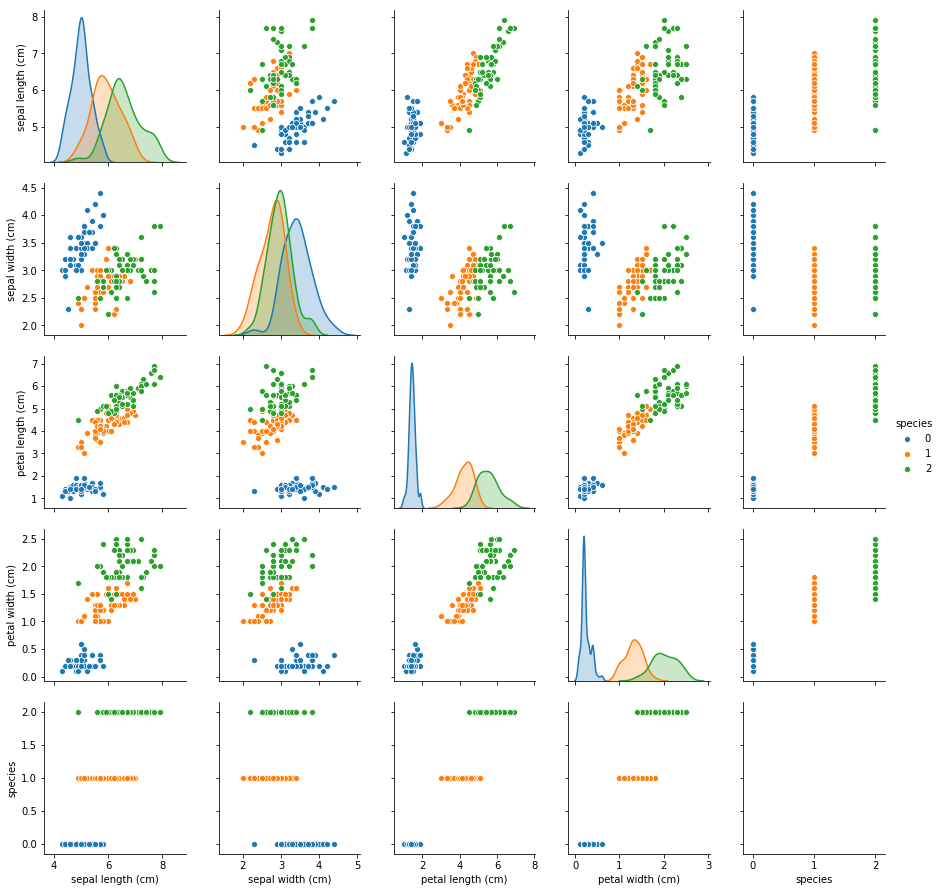

In [16]:
sns.pairplot(df, hue='species', diag_kind="kde")

визуально кажется, что ширина листка (petal width) даже самостоятельно может отделить два класса друг от друга идеально, а ещё для двух понадобится хотя бы ещё одна фича.

Возьмём пока для возможности изобразить это в 2D две фичи: длину и ширину листка

In [17]:
Xcut = X[X.columns[2:4]]

#### 2. Используем классификатор

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
# DecisionTreeClassifier?

In [20]:
clf = DecisionTreeClassifier(max_depth=2)

In [21]:
clf.fit(Xcut, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
clf.predict([ [1,1], [3,3] ])

array([0, 2])

In [23]:
df.species.unique()

array([0, 1, 2])

In [24]:
clf.predict_proba([ [1,1], [3,3] ])

array([[1.        , 0.        , 0.        ],
       [0.        , 0.02173913, 0.97826087]])

Супер, можем теперь предсказывать. Давайте визуализируем границу принятия решений. Для удобства экспереминтирования я упаковал всё в функцию **test_clf**, в неё передаётся созданный классификатор и при установленном fit_clf=True обучается внутри, а затем отрисовывает границу. Таким образом можно экспериментировать с параметрами классификатора

In [25]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [53]:
def test_clf(clf, X, y, cmap=None, fit_clf=False):
    xx,yy = get_grid(X.values)
    if fit_clf:
        clf.fit(X, y)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, predicted, cmap=cmap or 'spring')
    plt.scatter(X.values[:, 0], X.values[:, 1], c=y, s=100, cmap=cmap or 'spring')
    if fit_clf:
        return clf

*попробуйте при разной глубине*

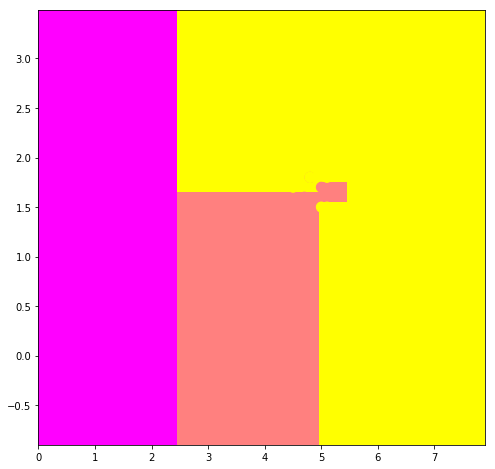

In [54]:
clf = test_clf(DecisionTreeClassifier(), Xcut, y.values.reshape(-1), fit_clf=True)

обратите внимание, один блок занимает то позицию снизу, то слева: данных недостаточно для принятия однозначного решения и экстраполяция идёт произвольно

#### 3. Визуализируем само дерево

Возможно, самое замечательное свойство одиночных деревьев - возможность визуализировать их алгоритм работы и затем объяснить его хоть человеку, хоть машине

Дерево можно как-то отобразить внутри ipython-ноутбука с помощью библиотеки pydot и установлнного webgraphviz, но мы воспользуемся скорее онлайн-сервисом http://www.webgraphviz.com

Сгенерируем код дерева в формате .dot и скопируем его на сайт

In [42]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [43]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xcut, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
clf.feature_importances_

array([0.58561555, 0.41438445])

In [1]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


NameError: name 'clf' is not defined

In [48]:
get_tree_dot_view(clf, list(Xcut.columns), iris.target_names)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="petal length (cm) <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa", fillcolor="#e5813900"] ;
1 [label="gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa", fillcolor="#e58139ff"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor", fillcolor="#39e58100"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="petal length (cm) <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor", fillcolor="#39e581e5"] ;
2 -> 3 ;
4 [label="gini = 0.041\nsamples = 48\nvalue = [0, 47, 1]\nclass = versicolor", fillcolor="#39e581fa"] ;
3 -> 4 ;
5 [label="gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]\nclass = virginica", fillcolor="#8139e57f"] ;
3 -> 5 ;
6 [label="petal length (cm) <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\ncla

-----

## 3. Оценка важности фичей

важность зависит от конкретного прогона классификатора, это не объективный показатель, но дающий представление

*попробуйте при разной глубине*

''

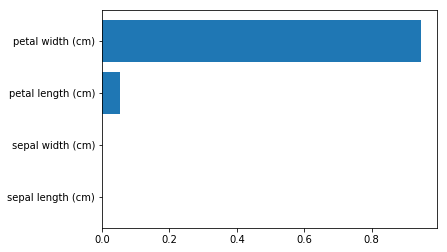

In [55]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)
''

## 4. Переообучение наглядно

*здесь я использую генерацию датасета из [блога](https://habrahabr.ru/company/ods/blog/322534/) open data science*

In [56]:
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
train_data = pd.DataFrame(train_data)

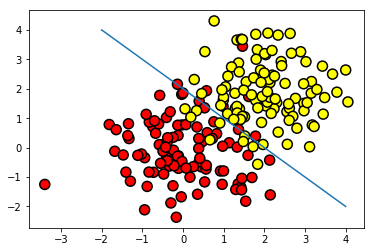

In [57]:
plt.scatter(train_data[0], train_data[1], c=train_labels, s=100, cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

*попробуйте при разной глубине*

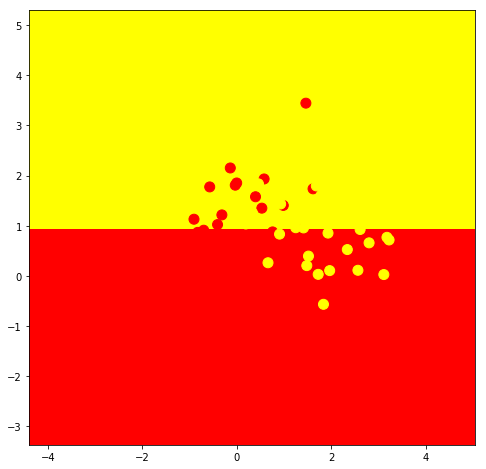

In [58]:
clf = test_clf(DecisionTreeClassifier(max_depth=1), train_data, train_labels, cmap='autumn', fit_clf=True)

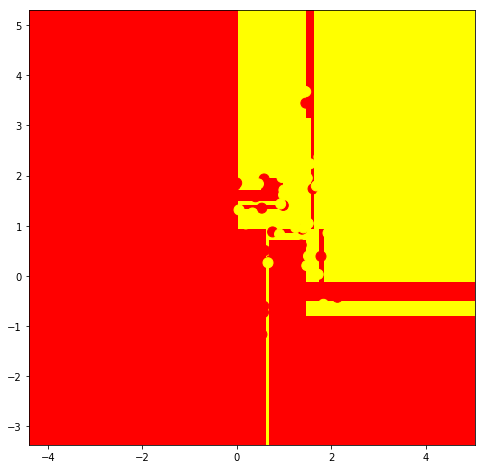

In [59]:
clf = test_clf(DecisionTreeClassifier(), train_data, train_labels, cmap='autumn', fit_clf=True)

А здесь можно увидеть огромное переобученное дерево: http://www.webgraphviz.com

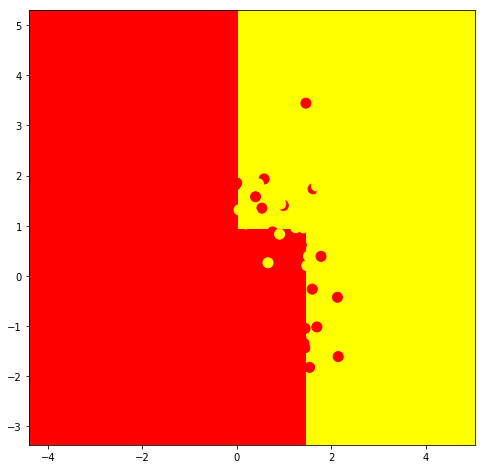

In [60]:
clf = test_clf(DecisionTreeClassifier(max_depth=2), train_data, train_labels, cmap='autumn', fit_clf=True)

In [63]:
clf = DecisionTreeClassifier(max_depth=10).fit(train_data, train_labels)

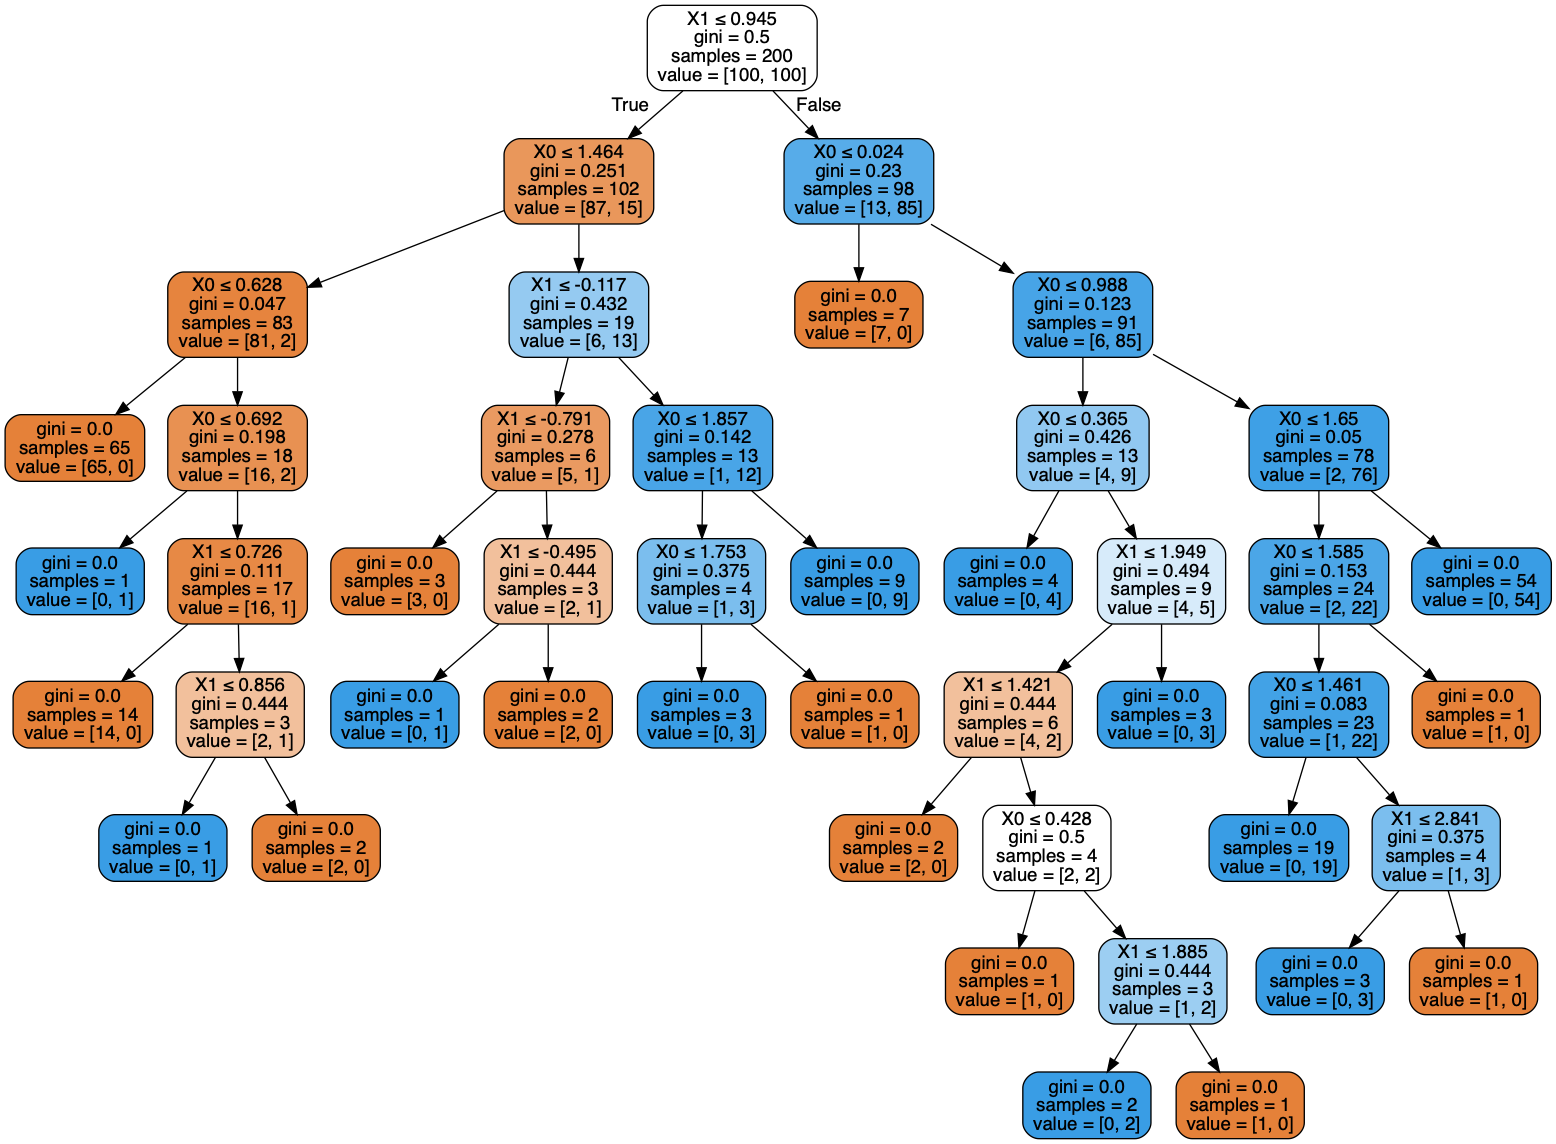

In [64]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [66]:
get_tree_dot_view(clf, feature_names=['x','y'])

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="y <= 0.945\ngini = 0.5\nsamples = 200\nvalue = [100, 100]", fillcolor="#e5813900"] ;
1 [label="x <= 1.464\ngini = 0.251\nsamples = 102\nvalue = [87, 15]", fillcolor="#e58139d3"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="x <= 0.628\ngini = 0.047\nsamples = 83\nvalue = [81, 2]", fillcolor="#e58139f9"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 65\nvalue = [65, 0]", fillcolor="#e58139ff"] ;
2 -> 3 ;
4 [label="x <= 0.692\ngini = 0.198\nsamples = 18\nvalue = [16, 2]", fillcolor="#e58139df"] ;
2 -> 4 ;
5 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]", fillcolor="#399de5ff"] ;
4 -> 5 ;
6 [label="y <= 0.726\ngini = 0.111\nsamples = 17\nvalue = [16, 1]", fillcolor="#e58139ef"] ;
4 -> 6 ;
7 [label="gini = 0.0\nsamples = 14\nvalue = [14, 0]", fillcolor="#e58139ff"] ;
6 -> 7 ;
8 [label="y <= 0.856\ngini = 0.444\nsamples = 3\nvalue = [2, 1]", fillcolor="#e581397f"] ;
6 -> 8 ;
9 [label="gini 